In this notebook I'm going to explore the data a bit. Let's see what we can find out about the enrollees and their openness to change their jobs.
Let's go!

In [1]:
''' import packages '''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

sns.set()

In [2]:
# load the data
HR = pd.read_csv('data/aug_train.csv')

In [3]:
# size of the data set
HR.shape

(19158, 14)

We have the data of nearly 20 k enrollees and 14 features - one of them the target variable. Let's have a first look at the dataframe.

In [4]:
# have a first look at the data
HR.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


From the Kaggle website I got the following information about the features:

- enrollee_id : Unique ID for candidate

- city: City code

- city_ development _index : Developement index of the city (scaled)

- gender: Gender of candidate

- relevent_experience: Relevant experience of candidate

- enrolled_university: Type of University course enrolled if any

- education_level: Education level of candidate

- major_discipline :Education major discipline of candidate

- experience: Candidate total experience in years

- company_size: No of employees in current employer's company

- company_type : Type of current employer

- last_new_job: Difference in years between previous job and current job

- training_hours: training hours completed

- target: 0 – Not looking for job change, 1 – Looking for a job change

Now I want to check how many values are missing per column.

In [5]:
# find out how many values are missing (per column)
missing = pd.DataFrame(HR.isnull().sum(), columns=["Amount"])
missing['Percentage'] = round((missing['Amount']/HR.shape[0])*100, 2)
missing

,Amount,Percentage
enrollee_id,0,0.00
city,0,0.00
city_development_index,0,0.00
gender,4508,23.53
relevent_experience,0,0.00
enrolled_university,386,2.01
education_level,460,2.40
major_discipline,2813,14.68
experience,65,0.34
company_size,5938,30.99


We have quite a few missing values, especially in the categories company_type (32%), company_size (31%), gender (24%) and major_discipline (15%). I will have to try to find out if these values are missing for a reason - maybe they mean something. Then it's easier to impute these values with something more meaningful.
Missingno is a nice tool to check whether there's an obvious pattern for the missing data.

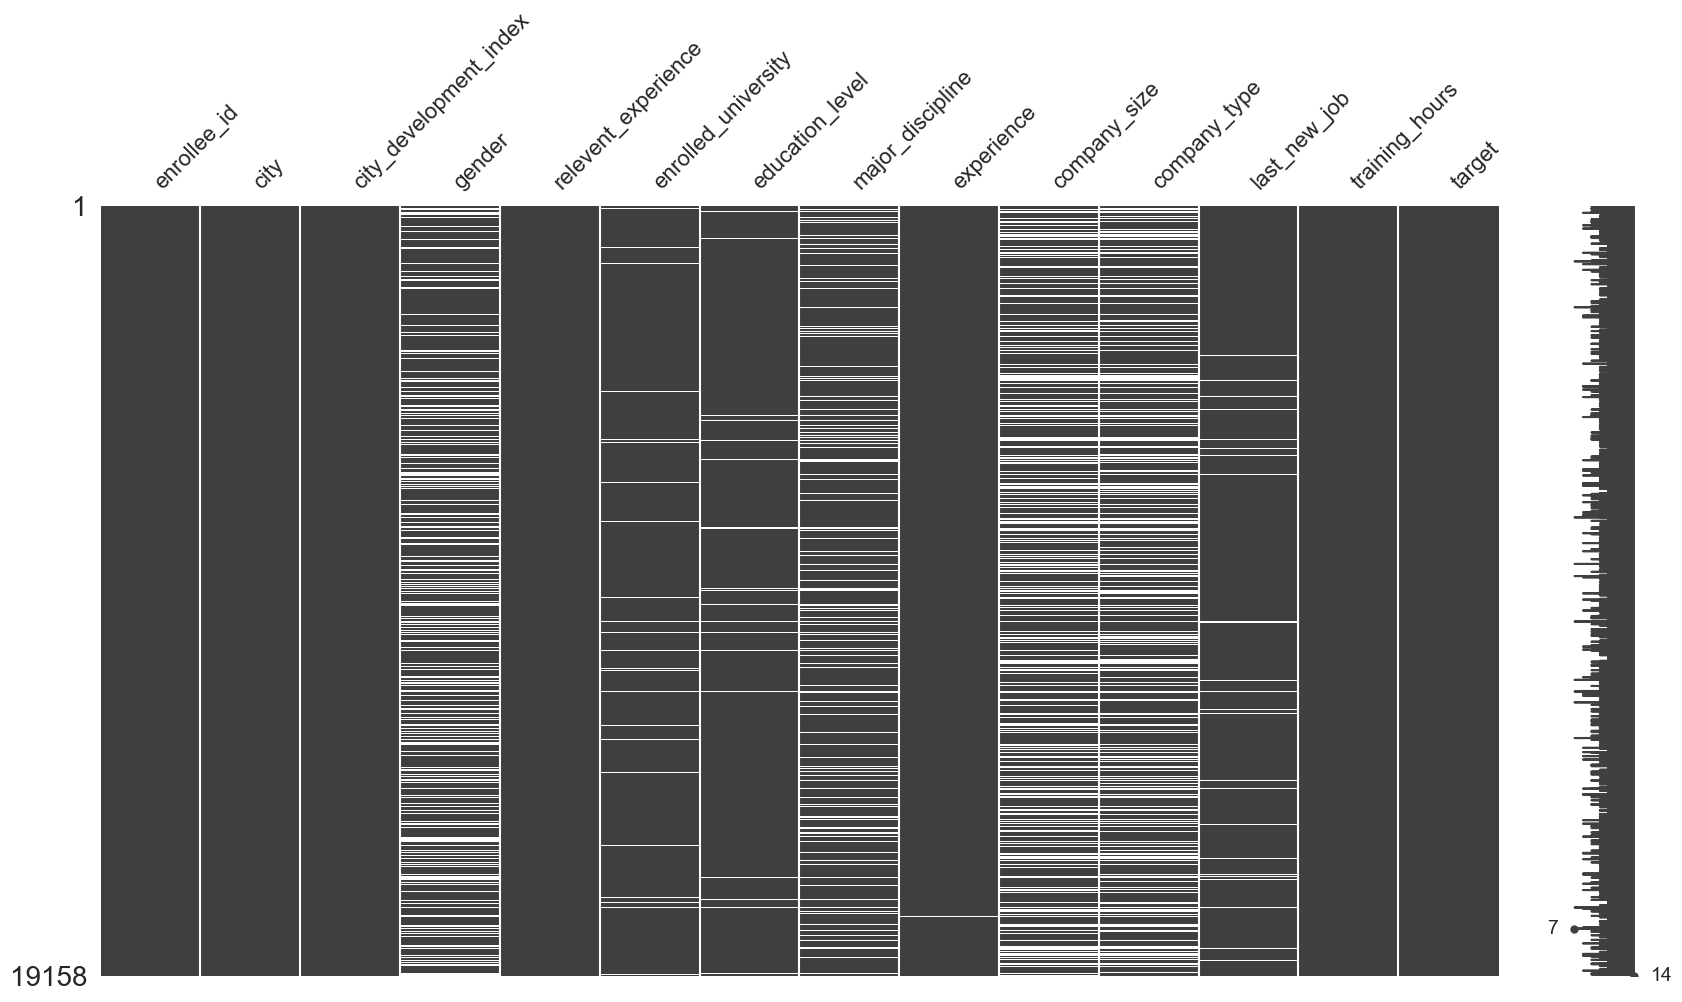

In [6]:
# check for pattern
msno.matrix(HR, figsize=(20,10));

We can see a pattern here: The features company_size and company_type are often missing at the same time (but not always). So in most cases there is either both information about the company or none at all. And we see: IF the education level is missing, then major_discipline is also missing. However, there are also a number of missing major_discipline entries where the education_level is present. 

We will have a closer look later.

Now I want to check which data types we're dealing with.

In [7]:
HR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

Most data in this data set is categorical.

Now we can check how many distinct values there are per column.

In [8]:
HR.nunique()

enrollee_id               19158
city                        123
city_development_index       93
gender                        3
relevent_experience           2
enrolled_university           3
education_level               5
major_discipline              6
experience                   22
company_size                  8
company_type                  6
last_new_job                  6
training_hours              241
target                        2
dtype: int64

There are no duplicates in the data set. (Number of distinct Enrollee IDs equals number of observations.) 
Enrollees are from 123 different cities. There are 93 different values for the City Development Index (CDI). There are 3 genders (probably male, female, diverse/other). There are 2 values for the relevant experience column (probably yes or no) and so on.

## EDA

I'll start exploring the data now. 

Let's start with the distribution of the target variable while 0 = not looking for a new job and 1 = looking for a new job.

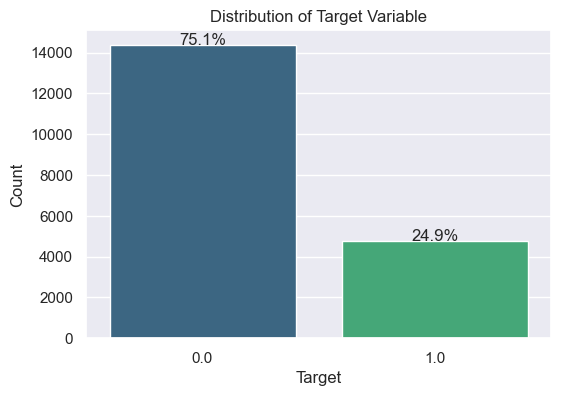

In [9]:
# plot distribution of target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=HR, palette='viridis')
total = len(HR['target'])
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2, height + 0.02, f'{height/total:.1%}', ha='center')

plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

The data set is imbalanced: Only 24,9% of the students are open for a job change.

The fact of imbalance will play a role again later in the model. For the EDA, this is not so important and we simply take note of this distribution for the time being.

I'll now plot the distribution of unique values for some of the categorical columns. It will just give me some quick insights on:
- which values do we have?
- how many are missing?
- how are they distributed?

I only do this for categorical data that has no more than 10 unique values

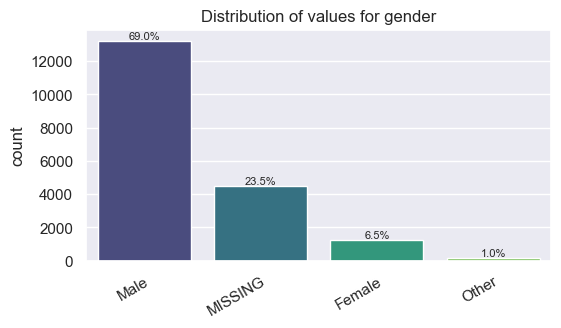

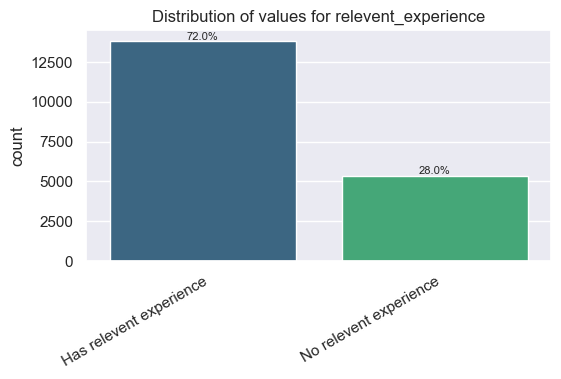

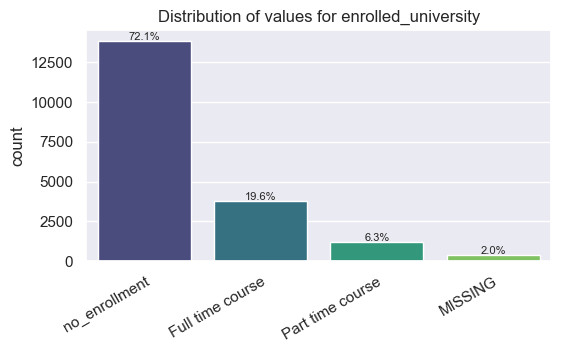

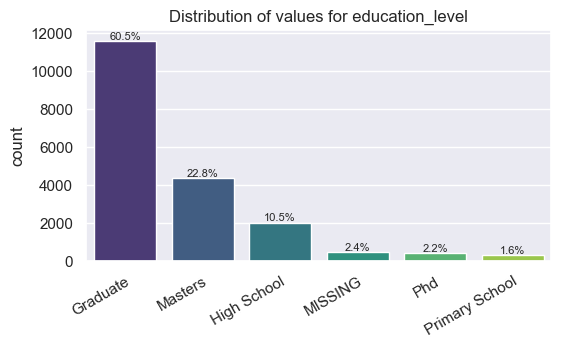

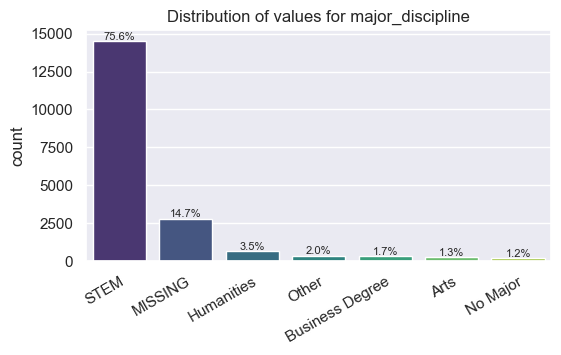

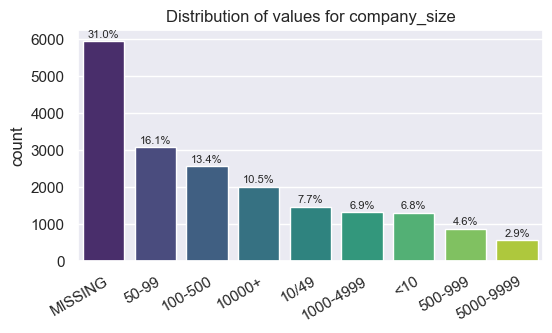

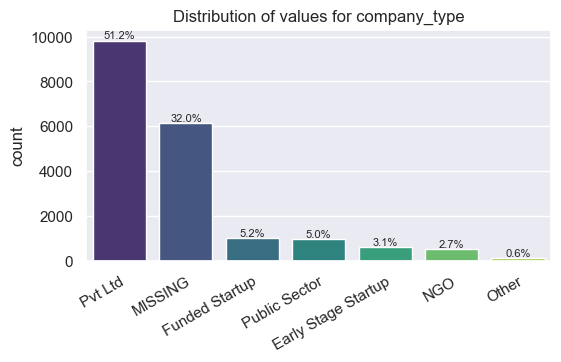

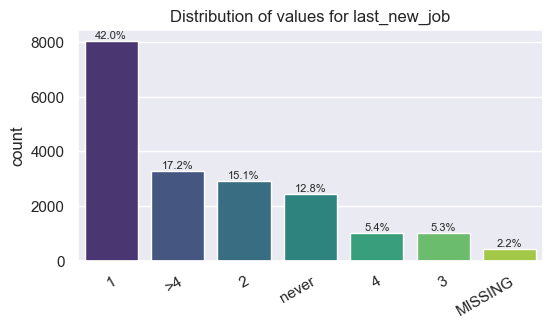

In [10]:
# fill all NaNs in the data frame with "MISSING"
HR_filled = HR.fillna('MISSING')

# list of features I want to have a look at
features = ['gender','relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'company_size', 'company_type', 'last_new_job']

# make a plot for each of these features
for feature in features:
    plt.figure(figsize=(6, 3))
    ax = sns.countplot(x=feature, data=HR_filled, palette='viridis', order=HR_filled[feature].value_counts().index)
    plt.title(f'Distribution of values for {feature}')

    total = len(HR_filled[feature])
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() + 0.005 * total  
        ax.text(x, y, percentage, ha='center', fontsize=8)  

    ax.set_xlabel('') 
    plt.xticks(rotation=30, rotation_mode='anchor', ha='right') 
    plt.show()

Ok, so what do we see here?

**Gender**: Most of the enrollees are men. But we also have 23.5% missing data. What could the missing data mean? That they are women or "other"? But these two categories also exist, so why weren't they used? I'm afraid we won't find out the gender of these enrollees using other columns either. So we will have no choice but to leave it at the imputation with "MISSING". 

**Relevant experience**: Most enrollee do have relevant experience, no data missing (yay!)

**Enrolled University**: What does this column actually mean? Apparently, whether the enrollee (in the Data Science course) is also enrolled at a regular university at the time of taking the course, and if so, full-time or part-time. We can see that most of the participants are not enrolled at a university, so they are not students (but presumably employees, which we can check again later when we look at other columns). This column is missing 2% of the data. We will see if we can impute this meaningfully. If necessary, they can perhaps be deleted, as there are very few of them.

**Education level**: Most of the participants are graduates, i.e. they have just finished their studies or training (and are just starting their careers?). Presumably they are bachelors, as there are also separate categories for masters and PhDs, with masters being the second largest group. After all, 10.5% only have a high school diploma. 2.4% of the data is missing. Here, too, we will have to see how we can deal with this later. I also wonder what enrollees who are still studying (full-time) have indicated in this question? The expected degree? 

**Major discipline**: The vast majority have studied a STEM subject. However, 14.7% of the data is missing. Perhaps those who did not study? (If we add up the 10.5% high school, 1.6% elementary school and 2.4% MISSING from the graphic above, we arrive at roughly this value. We should check that again later!

**Company size and company type**: The most interesting thing here is actually that just over 30% of the data is missing for both, in most cases this missingness occurs together, as we have already seen above. The question is: What does this mean? Maybe that the enrollee is not in any company at all? We have seen above that at least almost 20% of enrollees are full-time students. They will probably not be able to provide any information about any company because they are still studying. We will look at this connection later.

**Last new job**: The number of years between the last job and the current job, in other words, how long the enrollee has been in their current job.  Most (about? less than?) 1 year. Those who stated "never" are probably either students who have not had a job yet or employees who are still at their very first employer. Here again, just under 2 percent are missing. Do these mean anything? Do they perhaps also mean "never"? We don't know and it remains to be seen whether this will turn out to be the case. 

I'll now make a similar plot for the experience column. But it has so many different unique values that I want to display it a little differently. I first group the years in some reasonable buckets.

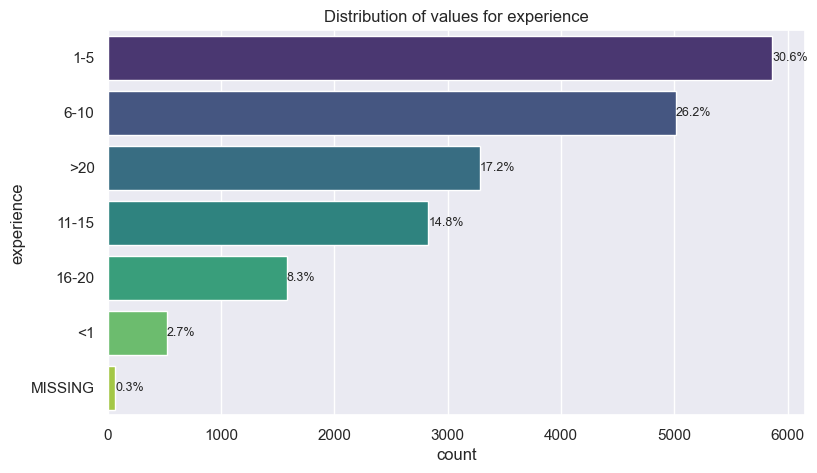

In [11]:
# group years
experience_mapping = {'MISSING': 'MISSING','<1': '<1','1': '1-5','2': '1-5','3': '1-5','4': '1-5','5': '1-5','6': '6-10','7': '6-10','8': '6-10','9': '6-10','10': '6-10','11': '11-15','12': '11-15','13': '11-15','14': '11-15','15': '11-15','16': '16-20','17': '16-20','18': '16-20','19': '16-20','20': '16-20','>20': '>20',}
HR_filled['experience_group'] = HR_filled['experience'].map(experience_mapping)

# plot experience groups
plt.figure(figsize=(9, 5))
ax = sns.countplot(data=HR_filled, y='experience_group', order=HR_filled['experience_group'].value_counts().head(HR_filled['experience_group'].nunique()).index, palette='viridis')

total = len(HR_filled.experience_group)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), fontsize=9, va='center')

plt.title('Distribution of values for experience')
plt.xlabel('count')
plt.ylabel('experience');

Most enrollees have 1-5 years of professional experience. No or little experience only a very few have.

I would now like to follow up on an assumption from above: Are the missing major_discipline due to the fact that the enrollees did not study at all?

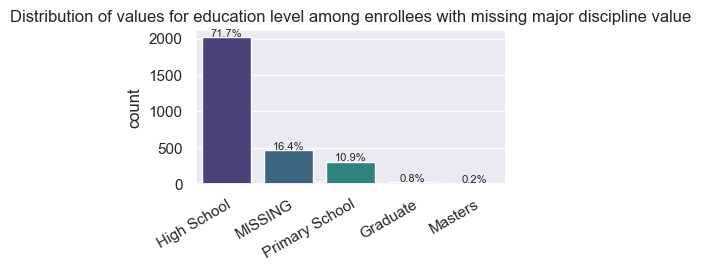

In [12]:
# create a data frame with all observations where the major discipline is missing
HR_missing_major_discipline = HR_filled.loc[HR_filled['major_discipline'] == 'MISSING']

# plot the distribtion of education levels in that data frame
plt.figure(figsize=(4, 2))
ax = sns.countplot(x='education_level', data=HR_missing_major_discipline, palette='viridis', order=HR_missing_major_discipline['education_level'].value_counts().index)
plt.title(f'Distribution of values for education level among enrollees with missing major discipline value')

total = len(HR_missing_major_discipline['education_level'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 0.005 * total  
    ax.text(x, y, percentage, ha='center', fontsize=8)  

ax.set_xlabel('') 
plt.xticks(rotation=30, rotation_mode='anchor', ha='right') 
plt.show()

I would say the assumption was confirmed. However, I would not derive any special measures from this now. I think we can leave the imputation with “MISSING”. (Also later for the model, I assume that the model recognizes the connection itself, if it is important at all.)

Now I would like to address the question of what it means if no information is provided about the company. I suspect that these enrollees are simply not employed anywhere at the moment. Unfortunately there is no column “currently employed yes or no”. One could also assume that those who are not currently employed may also be the ones who are particularly open to a job "change". **This is something we definitely need to investigate, after all it directly affects our target variable!**

What other variables may give us the information whether someone is employed or not?

In [13]:
# have a look at the columns again
HR.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

Difficult! Maybe *enrolled_university*: Someone who studies full-time probably doesn't work?

I'll just create a data frame that contains all of them where both company_size and company_size are missing and take a look at it.

In [14]:
# create a data frame with all observations where the company_size and company_type are missing at the same time
HR_missing_company = HR_filled.loc[(HR_filled['company_size'] == 'MISSING') & (HR_filled['company_type'] == 'MISSING')]

# have a look
HR_missing_company.head(20)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target,experience_group
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,MISSING,MISSING,1,36,1.0,>20
2,11561,city_21,0.624,MISSING,No relevent experience,Full time course,Graduate,STEM,5,MISSING,MISSING,never,83,0.0,1-5
5,21651,city_176,0.764,MISSING,Has relevent experience,Part time course,Graduate,STEM,11,MISSING,MISSING,1,24,1.0,11-15
10,29452,city_21,0.624,MISSING,No relevent experience,Full time course,High School,MISSING,2,MISSING,MISSING,never,32,1.0,1-5
13,5826,city_21,0.624,Male,No relevent experience,MISSING,MISSING,MISSING,2,MISSING,MISSING,never,24,0.0,1-5
14,8722,city_21,0.624,MISSING,No relevent experience,Full time course,High School,MISSING,5,MISSING,MISSING,never,26,0.0,1-5
19,11399,city_13,0.827,Female,Has relevent experience,no_enrollment,Graduate,Arts,4,MISSING,MISSING,1,132,1.0,1-5
22,6491,city_102,0.804,MISSING,Has relevent experience,no_enrollment,Masters,STEM,10,MISSING,MISSING,1,48,0.0,6-10
25,14505,city_67,0.855,MISSING,No relevent experience,no_enrollment,High School,MISSING,4,MISSING,MISSING,never,22,0.0,1-5
27,28476,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,Arts,5,MISSING,MISSING,2,72,0.0,1-5


I don't see a pattern that helps us understand whether MISSING in both columns indicates current unemployment. You can also see here that there is apparently no connection to enrolled_university but let's have a closer look:

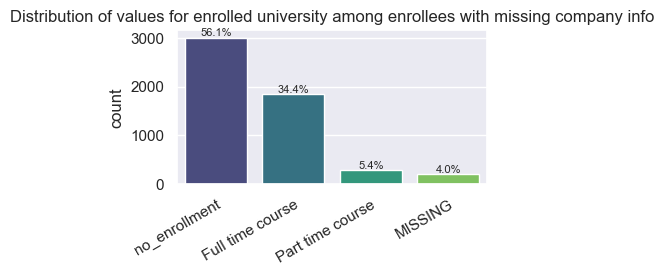

In [15]:
# plot the distribtion of enrolled_university in that data frame
plt.figure(figsize=(4, 2))
ax = sns.countplot(x='enrolled_university', data=HR_missing_company, palette='viridis', order=HR_missing_company['enrolled_university'].value_counts().index)
plt.title(f'Distribution of values for enrolled university among enrollees with missing company info')

total = len(HR_missing_company['enrolled_university'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 0.005 * total  
    ax.text(x, y, percentage, ha='center', fontsize=8)  

ax.set_xlabel('') 
plt.xticks(rotation=30, rotation_mode='anchor', ha='right') 
plt.show()

No new insights. I'm now interested whether the distribution of the target variable is different in this company:

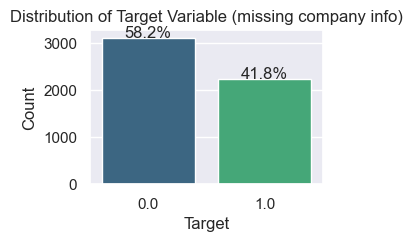

In [16]:
# plot distribution of target variable
plt.figure(figsize=(3, 2))
sns.countplot(x='target', data=HR_missing_company, palette='viridis')
total = len(HR_missing_company['target'])
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2, height + 0.02, f'{height/total:.1%}', ha='center')

plt.title('Distribution of Target Variable (missing company info)')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

It is definitely the case that the willingness to change jobs is higher among enrollees for whom no information about the company was provided than in the entire data set. This could indicate that some people here are unemployed, as I suspected. But unfortunately we can't check it exactly.

For the sake of completeness, we'll show you the most common cities, even if we don't know which ones are behind them.

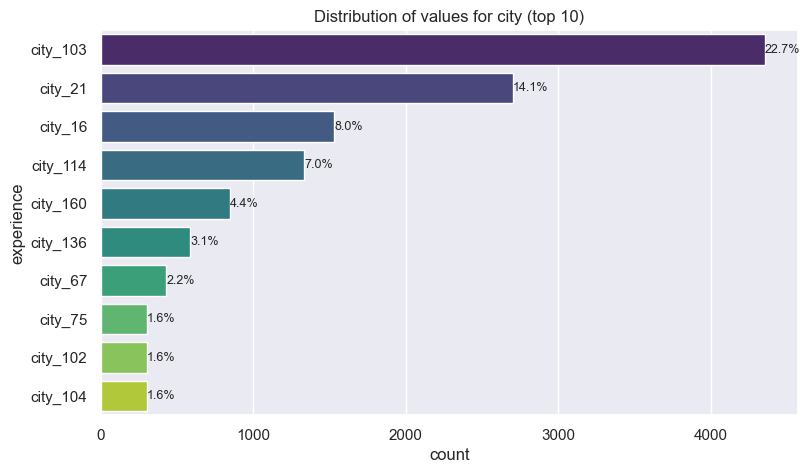

In [17]:
# plot cities
plt.figure(figsize=(9, 5))
ax = sns.countplot(data=HR_filled, y='city', order=HR_filled['city'].value_counts().head(10).index, palette='viridis')

total = len(HR_filled.city)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), fontsize=9, va='center')

plt.title('Distribution of values for city (top 10)')
plt.xlabel('count')
plt.ylabel('experience');

Most enrollees are from city_103...

Let's now check the distribution of the numerical variables. We start with the training hours.

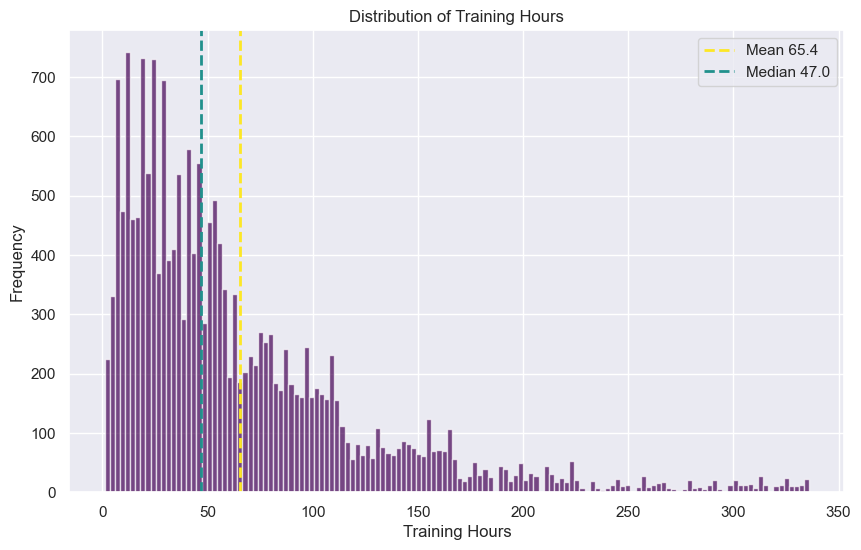

In [31]:
mean_training_hours = HR_filled['training_hours'].mean()
median_training_hours = HR_filled['training_hours'].median()
plt.figure(figsize=(10, 6))
plt.hist(HR_filled['training_hours'], bins=int(np.sqrt(len(HR_filled['training_hours']))), color='#440154', edgecolor='white', alpha=0.7)
plt.axvline(mean_training_hours, color='#fde725', linestyle='dashed', linewidth=2, label=f'Mean {HR_filled["training_hours"].mean().round(1)}')
plt.axvline(median_training_hours, color='#21918c', linestyle='dashed', linewidth=2, label=f'Median {HR_filled["training_hours"].median().round(1)}')
plt.title('Distribution of Training Hours')
plt.xlabel('Training Hours')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

We see a right skewed distribution. On average, enrollees have 65.4 (mean) or 47 (median) training hours. We can also look at the whole thing again as a boxplot to see the outlier better:

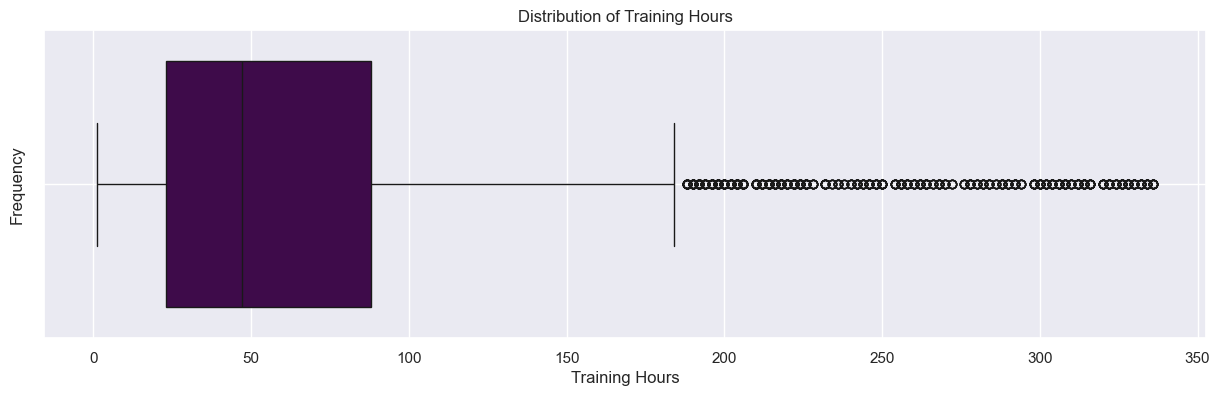

In [30]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=HR_filled, x='training_hours', color='#440154')
plt.title('Distribution of Training Hours')
plt.xlabel('Training Hours')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The upper (right) whisker represents the maximum data value that is still within the 1.5 times IQR range from the third quartile. All observations right to it are considered outliers. We see that it's quite a lot. It doesn't mean that these values are wrong, they are just not typical for this variable in this dataset. (Since we the data is quite concentrated in the area between 23 and 88 hours.) Let's count how many outliers we have exactly:

In [20]:
# find first and third quartile
Q1 = HR_filled['training_hours'].quantile(0.25)
Q3 = HR_filled['training_hours'].quantile(0.75)

# calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# identify outliers
outliers = HR_filled[(HR_filled['training_hours'] < lower_bound) | (HR_filled['training_hours'] > upper_bound)]

# count the number of outliers
num_outliers = len(outliers)

# calculate percentage of outliers in entire dataset
percentage_outliers = (num_outliers / len(HR_filled)) * 100

# print the results
print(f'Number of outliers: {num_outliers}')
print(f'Percentage of outliers in the dataset: {percentage_outliers:.2f}%')

Number of outliers: 984
Percentage of outliers in the dataset: 5.14%


5% of ouf the data are considered outliers for the training hours variable. This is not too much. I would still keep them for now, as they may be correct values,too. We will see with the model whether it performs better without an outlier.

Let's now check the city development index (CDI) column. I've checked [Wikipedia](https://en.wikipedia.org/wiki/City_development_index) for more information about this variable. It is calculated according to a special formula that contains information about infrastructure, waste, health, education and product. It gives a values between 0 and 1 while 0 is bad and 1 is good.

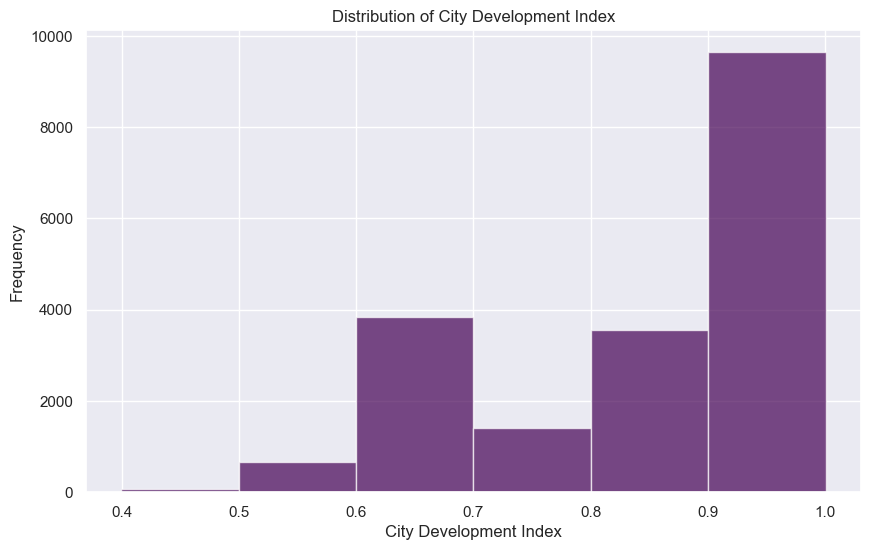

In [28]:
plt.figure(figsize=(10, 6))
bin_edges = [0.39995, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0005]

plt.hist(HR_filled['city_development_index'], bins=bin_edges, color='#440154', alpha=0.7)
plt.title('Distribution of City Development Index')
plt.xlabel('City Development Index')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Most enrollees are from cities with a very hight CDI between 0.9 and 1.0. The lowest values is 0.4.


Now that we have looked at the individual variables and their distributions and also tried to find out more about the missing values, let's now look at each variable in relation to the target variable.

In [26]:
HR_filled.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target', 'experience_group'],
      dtype='object')

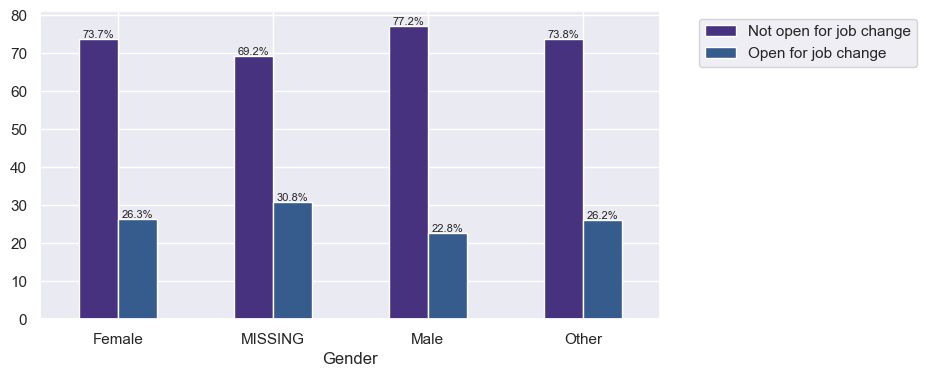

In [74]:
df_gender = pd.crosstab(HR_filled['gender'], HR_filled['target'], normalize='index').mul(100).round(2)

custom_palette = sns.color_palette("viridis")

ax = df_gender.plot.bar(figsize=(8, 4), rot=0, color=custom_palette)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 3), textcoords='offset points', fontsize=8)

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', labels=['Not open for job change', 'Open for job change'])
plt.xlabel("Gender")
plt.show()

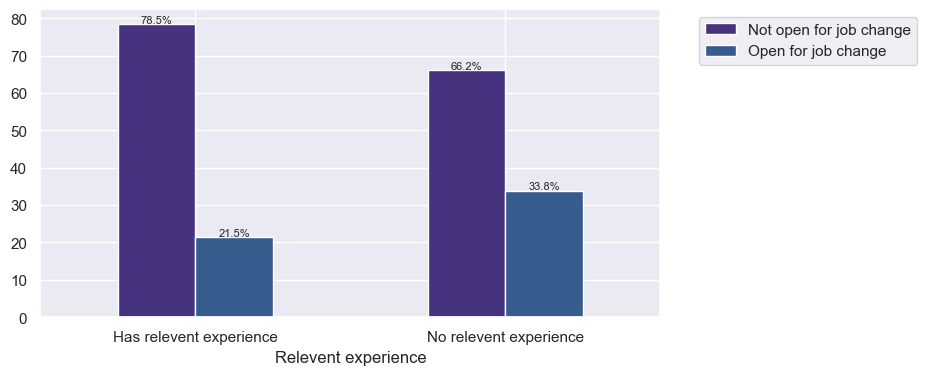

In [77]:
df_relevent_experience = pd.crosstab(HR_filled['relevent_experience'], HR_filled['target'], normalize='index').mul(100).round(2)

ax = df_relevent_experience.plot.bar(figsize=(8, 4), rot=0, color=custom_palette)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 3), textcoords='offset points', fontsize=8)

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', labels=['Not open for job change', 'Open for job change'])
plt.xlabel("Relevent experience")
plt.show()

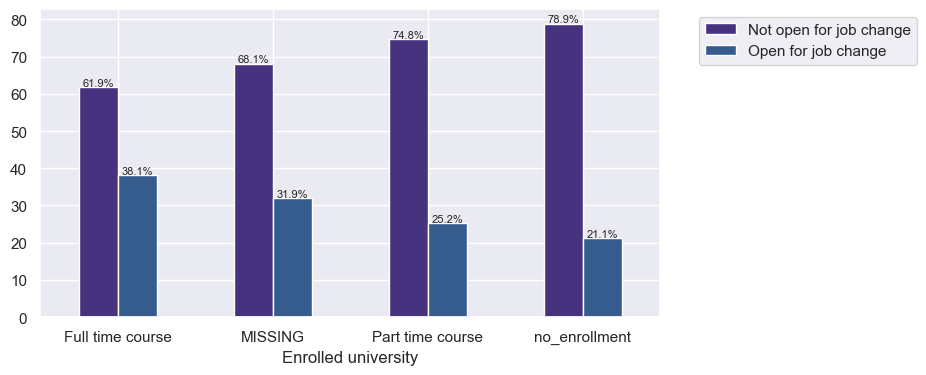

In [79]:
df_enrolled_university = pd.crosstab(HR_filled['enrolled_university'], HR_filled['target'], normalize='index').mul(100).round(2)

ax = df_enrolled_university.plot.bar(figsize=(8, 4), rot=0, color=custom_palette)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 3), textcoords='offset points', fontsize=8)

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', labels=['Not open for job change', 'Open for job change'])
plt.xlabel("Enrolled university")
plt.show()

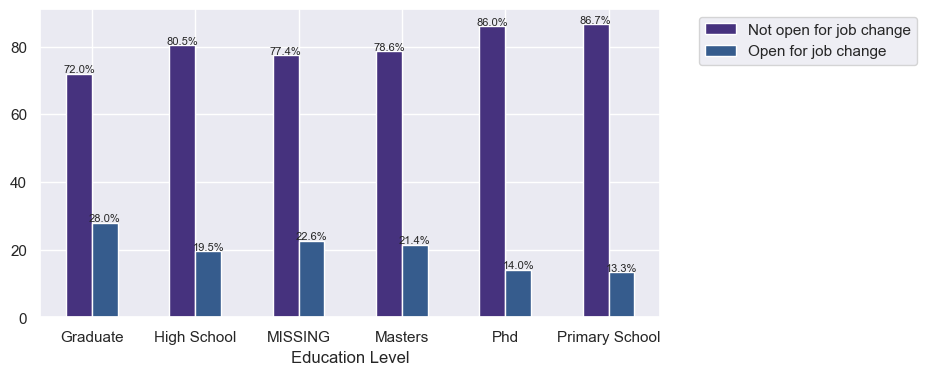

In [80]:
df_education_level = pd.crosstab(HR_filled['education_level'], HR_filled['target'], normalize='index').mul(100).round(2)

ax = df_education_level.plot.bar(figsize=(8, 4), rot=0, color=custom_palette)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 3), textcoords='offset points', fontsize=8)

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', labels=['Not open for job change', 'Open for job change'])
plt.xlabel("Education Level")
plt.show()